# 

## Install Python libraries
* To temporarily install Python libraries for server use, use the command: `%pip`.

In [1]:
%pip install simplekml
%pip install geopy
%pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Python libraries

In [2]:
from sliderule import sliderule, icesat2, earthdata
import geopandas as gpd
import pandas as pd
import folium
import numpy as np
from shapely.geometry import Polygon, Point, mapping
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.linear_model import LinearRegression
import geopy
import simplekml
from geopy.distance import geodesic
from matplotlib.backends.backend_pdf import PdfPages
import plotly.express as px
from tqdm import tqdm
import warnings
from scipy.stats import linregress

In [3]:
segment_meter = "100"
cnt = "10"
ats = "10"

# site_name = "BONA"
# site_name = "DEJU"
# site_name = "WREF"
# site_name = "RMNP"
# site_name = "TEAK"

boundary_km = "50"

year_folder = 'year/'
day_folder = 'day/'

In [4]:
def compile_dates_for_site(folder, site_name):
    """
    Reads all CSV files for the specified site in a folder, extracts the 'date' column,
    and compiles a unique list of dates.

    Args:
        folder (str): The directory containing the CSV files.

    Returns:
        list: A sorted list of unique dates for the specified site.
    """
    print(site_name)
    all_dates = set()  # Use a set to ensure unique dates

    # Iterate through all files in the folder
    for filename in os.listdir(folder):
        if filename.startswith(site_name) and filename.endswith(".csv"):  # Match site_name in the file name
            filepath = os.path.join(folder, filename)
            try:
                # Read the CSV file into a DataFrame
                df = pd.read_csv(filepath)
                if 'date' in df.columns and 'ground_photon_count' in df.columns and 'canopy_photon_count' in df.columns:
                    # Filter rows where both ground_photon_count and canopy_photon_count are 0
                    filtered_df = df[(df['ground_photon_count'] != 0) | (df['canopy_photon_count'] != 0)]
                    # Add unique dates directly from the 'date' column as strings
                    all_dates.update(filtered_df['date'].dropna().unique())
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    # Return sorted list of unique dates
    return sorted(all_dates)

site_dates = compile_dates_for_site(year_folder, site_name)
print(site_dates)

WREF
['2019-02-20', '2019-05-29', '2019-08-21', '2020-02-19', '2020-02-25', '2020-08-18', '2020-08-25', '2020-11-23', '2021-08-16', '2021-08-23', '2022-05-22', '2022-07-17', '2022-08-15', '2022-08-21', '2022-11-14', '2023-02-12', '2023-05-14', '2023-05-21', '2023-08-13', '2023-08-19']


In [5]:
def generate_date_time_ranges(dates):
    """
    Generate a dictionary of start and end times for each unique date.

    Args:
        dates (list of str): List of date strings in the format "YYYY-MM-DD".
        
    Returns:
        list of dict: A list of dictionaries where each dictionary represents a time range
                      with 'start_time' and 'end_time' for a specific date.
    """
    time_ranges = []
    for date in dates:
        start_time = f"{date}T00:00:00Z"
        end_time = f"{date}T23:59:59Z"
        
        # Append the date with its start_time and end_time to the time_ranges list
        time_ranges.append({
            "date": date, 
            "start_time": start_time, 
            "end_time": end_time
        })
    return time_ranges

site_time_ranges = generate_date_time_ranges(site_dates)
print(site_name)
for date in site_time_ranges:
    print(date)
print(len(site_time_ranges))

WREF
{'date': '2019-02-20', 'start_time': '2019-02-20T00:00:00Z', 'end_time': '2019-02-20T23:59:59Z'}
{'date': '2019-05-29', 'start_time': '2019-05-29T00:00:00Z', 'end_time': '2019-05-29T23:59:59Z'}
{'date': '2019-08-21', 'start_time': '2019-08-21T00:00:00Z', 'end_time': '2019-08-21T23:59:59Z'}
{'date': '2020-02-19', 'start_time': '2020-02-19T00:00:00Z', 'end_time': '2020-02-19T23:59:59Z'}
{'date': '2020-02-25', 'start_time': '2020-02-25T00:00:00Z', 'end_time': '2020-02-25T23:59:59Z'}
{'date': '2020-08-18', 'start_time': '2020-08-18T00:00:00Z', 'end_time': '2020-08-18T23:59:59Z'}
{'date': '2020-08-25', 'start_time': '2020-08-25T00:00:00Z', 'end_time': '2020-08-25T23:59:59Z'}
{'date': '2020-11-23', 'start_time': '2020-11-23T00:00:00Z', 'end_time': '2020-11-23T23:59:59Z'}
{'date': '2021-08-16', 'start_time': '2021-08-16T00:00:00Z', 'end_time': '2021-08-16T23:59:59Z'}
{'date': '2021-08-23', 'start_time': '2021-08-23T00:00:00Z', 'end_time': '2021-08-23T23:59:59Z'}
{'date': '2022-05-22', 's

In [6]:
%%time

def process_site(site, time_ranges, boundary_km):
    """
    Processes a site by requesting ATL03 data for specified time ranges.

    Args:
        region (dict): A dictionary containing the spatial region of interest, with a 'poly' key for the polygon.
        time_ranges (dict): A dictionary where keys are years, and values are dictionaries with 'start_time' and 'end_time'.
        cnt (int, optional): Number of photons required for the analysis. Defaults to None.
        ats (int, optional): Along-track spacing for the data. Defaults to None.
        segment_meter (float, optional): Segment length and resolution in meters. Defaults to 10.

    Returns:
        dict: A dictionary where keys are years, and values are the retrieved ATL03 data.
    """
    # Load the region dynamically based on the site
    region = sliderule.toregion(f"geojson_files/{site}_buffer_{boundary_km}km.geojson")
    
    # Dictionary to store ATL03 data for each year
    site_data = {}
    
    for time_range  in time_ranges:
        # Construct the parameters for the current time range
        parms = {
            "poly": region['poly'],       # Region polygon
            "t0": time_range['start_time'],   # Start time
            "t1": time_range['end_time'],     # End time
            "srt": icesat2.SRT_LAND,           # Surface return type
            "cnf": 3,                    # Confidence level (2 is low-confidence)
            "cnt": cnt,                  # Number of photons
            "ats": ats,                  # Along-track spacing
            "len": segment_meter,        # Segment length
            "res": segment_meter,        # Resolution
            "atl08_class": [             # ATL08 classifications
                "atl08_noise",
                "atl08_ground",
                "atl08_canopy",
                "atl08_top_of_canopy",
                "atl08_unclassified"
            ],
            "phoreal": {                 # Phoreal processing settings
                "binsize": 1.0,
                "geoloc": "mean",
                "use_abs_h": True,
                "send_waveform": True
            }
        }

        # Request the ATL03 data using icesat2
        atl03_data = icesat2.atl03sp(parms, keep_id=True)

        columns_to_drop = [
        'region', 'pair', 'segment_dist', 'segment_id', 'cycle', 'track', 'background_rate', 'y_atc', 'x_atc', 
            'yapc_score', 'atl03_cnf', 'relief', 'quality_ph'
        ]
        
        # Drop the columns from the DataFrame
        atl03_data = atl03_data.drop(columns=columns_to_drop)
        
        # Use the date as the key for storing data
        site_data[time_range['date']] = atl03_data

    return site_data

site_data = process_site(site_name, site_time_ranges, boundary_km)

CPU times: user 1min 30s, sys: 2.12 s, total: 1min 32s
Wall time: 2min 22s


In [7]:
# Loop through the site_data dictionary

print (len(site_data))
for date, site_datum in site_data.items():
    print(f"Date: {date}")
    print("Columns:", site_datum.columns.tolist())  # Print the list of column names

20
Date: 2019-02-20
Columns: ['sc_orient', 'solar_elevation', 'rgt', 'extent_id', 'height', 'landcover', 'atl08_class', 'snowcover', 'geometry', 'spot']
Date: 2019-05-29
Columns: ['sc_orient', 'solar_elevation', 'rgt', 'extent_id', 'height', 'landcover', 'atl08_class', 'snowcover', 'geometry', 'spot']
Date: 2019-08-21
Columns: ['sc_orient', 'solar_elevation', 'rgt', 'extent_id', 'height', 'landcover', 'atl08_class', 'snowcover', 'geometry', 'spot']
Date: 2020-02-19
Columns: ['sc_orient', 'solar_elevation', 'rgt', 'extent_id', 'height', 'landcover', 'atl08_class', 'snowcover', 'geometry', 'spot']
Date: 2020-02-25
Columns: ['sc_orient', 'solar_elevation', 'rgt', 'extent_id', 'height', 'landcover', 'atl08_class', 'snowcover', 'geometry', 'spot']
Date: 2020-08-18
Columns: ['sc_orient', 'solar_elevation', 'rgt', 'extent_id', 'height', 'landcover', 'atl08_class', 'snowcover', 'geometry', 'spot']
Date: 2020-08-25
Columns: ['sc_orient', 'solar_elevation', 'rgt', 'extent_id', 'height', 'landcov

In [8]:
%%time
def process_photons(site_data):
    """
    Processes site data to calculate canopy and terrain photon rates for each segment and checks for duplicate times.

    Args:
        site_data (dict): A dictionary where each value is a DataFrame containing data for a site.

    Returns:
        dict: A dictionary with the same keys as `site_data`, containing processed DataFrames.
    """
    processed_data = {}

    for date, data in site_data.items():
        # Ensure 'time' is the index and in datetime format
        data.index = pd.to_datetime(data.index)

        # Extract latitude and longitude from the 'geometry' column
        data['latitude'] = data['geometry'].apply(lambda x: x.y if x else None)
        data['longitude'] = data['geometry'].apply(lambda x: x.x if x else None)

        # Separate photons into canopy and terrain classes
        canopy_photons = data[data['atl08_class'].isin([2, 3])]  # Classes 2 and 3 for canopy
        terrain_photons = data[data['atl08_class'] == 1]         # Class 1 for ground

        # Count photons for each segment
        canopy_counts = canopy_photons.groupby('extent_id').size().reset_index(name='canopy_photon_count')
        terrain_counts = terrain_photons.groupby('extent_id').size().reset_index(name='terrain_photon_count')

        # Convert the index to a column temporarily
        data['time_index'] = data.index
        
        # Group by 'extent_id' and count unique 'time_index' values (representing unique times)
        unique_time_count = (
            data.groupby('extent_id')['time_index']
            .nunique()
            .reset_index(name='unique_shots')
        )
        
        # Drop the temporary 'time_index' column
        data = data.drop(columns='time_index')

        # Merge canopy and terrain counts into one DataFrame
        segment_counts = (
            canopy_counts
            .merge(terrain_counts, on='extent_id', how='outer')
            .merge(unique_time_count, on='extent_id', how='outer')
        )

        # Replace any zero or NaN values in 'unique_shots' with NaN to avoid division by zero errors
        segment_counts['unique_shots'] = segment_counts['unique_shots'].replace(0, np.nan)

        # Calculate photon rates by normalizing with the number of unique shots
        segment_counts['canopy_photon_rate'] = segment_counts['canopy_photon_count'] / segment_counts['unique_shots']
        segment_counts['terrain_photon_rate'] = segment_counts['terrain_photon_count'] / segment_counts['unique_shots']

        # Reset index to keep 'time' as a column for merging
        data = data.reset_index()

        # Merge photon rates into the main DataFrame
        data = data.merge(
            segment_counts[['extent_id', 'canopy_photon_rate', 'terrain_photon_rate']], 
            on='extent_id', how='left'
        )

        # Check for duplicates in the 'time' column
        duplicate_times = data[data.index.duplicated()]

        # Log duplicates if needed (optional)
        if not duplicate_times.empty:
            print(f"date {date}: Found duplicate times in the 'time' column.")

        # Store processed data
        processed_data[date] = data

    return processed_data

processed_site_data = process_photons(site_data)

CPU times: user 1min 51s, sys: 1.04 s, total: 1min 52s
Wall time: 1min 51s


In [9]:
%time
def output_photon_counts_by_day(processed_site_data, output_dir, boundary_km):
    """
    Outputs photon counts by day for each site, separated by ATL08 categories, into CSV files.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing processed data for a site.
        output_dir (str): The directory where the CSV files should be saved.
        site_name (str): The name of the site (used for output file naming).
        ats (str): The ATS value (used for output file naming).

    Returns:
        None
    """
    # Define ATL08 classification categories and their values
    atl08_categories = {
        "unclassified": 0,
        "ground": 1,
        "canopy": 2,
        "top_of_canopy": 3,
        "noise": 4
    }
        
    # Dictionary to track open file handles for each year
    file_handles = {}
    
    try:
        for date_str, data in processed_site_data.items():
            # Parse the year from the date string
            year = pd.to_datetime(date_str).year

            # Ensure 'date' column is included
            data['date'] = pd.to_datetime(date_str).strftime('%Y-%m-%d')

            # Count photons for each ATL08 category
            category_counts = {}
            for category, value in atl08_categories.items():
                category_counts[category] = (data[data['atl08_class'] == value].groupby('date').size().reset_index(name=f"{category}_photon_count"))

            # Count unique segments (extent_id) for each date
            segment_counts_by_date = (data.groupby('date')['extent_id'].nunique().reset_index(name="segment_count"))
    
            # Start with the segment counts
            counts_by_date = segment_counts_by_date
    
            # Merge counts for each ATL08 category
            for category, count_df in category_counts.items():
                counts_by_date = counts_by_date.merge(count_df, on="date", how="outer")
    
            # Fill NaN values with 0 for days where no photons are present in a category
            counts_by_date.fillna(0, inplace=True)
            
            savepath = os.path.join(output_dir, site_name)
            # Ensure the output directory exists
            if not os.path.exists(savepath):
                os.makedirs(savepath)
                
            # If the file for this year hasn't been initialized, create it with headers
            if year not in file_handles:
                savefile = os.path.join(output_dir, site_name, f'{site_name}_photons_{year}_ats{ats}_{boundary_km}km.csv')
                file_handles[year] = savefile
                counts_by_date.to_csv(savefile, index=False)
            else:
                # Append to the existing file for the year
                counts_by_date.to_csv(file_handles[year], index=False, mode='a', header=False)

    finally:
        # Close file handles if necessary (pandas handles this implicitly, but good practice)
        file_handles.clear()

output_photon_counts_by_day(processed_site_data, day_folder, boundary_km)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [10]:
# # Adjust display options
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)        # Use full width of the terminal
# pd.set_option('display.expand_frame_repr', False)  # Avoid column wrapping

# # Group by 'extent_id' and 'spot', then get the first row for each unique combination
# unique_spot_rows = processed_site_data["2023-04-21"].drop_duplicates(subset=['extent_id', 'spot'])

# # Display the result
# print(len(unique_spot_rows))
# # unique_spot_rows.head(50)
# print(unique_spot_rows.head())
# del unique_spot_rows

In [11]:
%%time
def add_landcover_and_date_info(processed_site_data):
    """
    Adds landcover mode and date-related columns (month, year, day) to each site DataFrame in processed_site_data.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing data for a site.

    Returns:
        dict: A dictionary with the same keys as `processed_site_data`, containing updated DataFrames.
    """
    valid_landcover_codes = {111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20}

    updated_data = {}

    for date, data in processed_site_data.items():
        # Step 1: Ensure there are no invalid landcover values before grouping
        valid_landcover_data = data[data["landcover"].isin(valid_landcover_codes)].copy()

        # Step 2: Calculate the landcover mode for each extent_id
        landcover_modes = valid_landcover_data.groupby("extent_id")["landcover"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

        # Step 3: Assign the calculated mode back to the original DataFrame
        data["landcover_mode"] = data["extent_id"].map(landcover_modes)

        # Step 4: Set 'time' back as the index if not already
        if "time" in data.columns:
            data.set_index("time", inplace=True)
            data.index = pd.to_datetime(data.index)

        # Step 5: Extract month, year, and day for aggregation
        data["month"] = data.index.month
        data["year"] = data.index.year
        data["day"] = data.index.day

        # Store the updated DataFrame in the dictionary
        updated_data[date] = data

    return updated_data

processed_site_data = add_landcover_and_date_info(processed_site_data)

CPU times: user 6.59 s, sys: 59.9 ms, total: 6.65 s
Wall time: 6.65 s


In [12]:
# # Adjust display options
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)        # Use full width of the terminal
# pd.set_option('display.expand_frame_repr', False)  # Avoid column wrapping

# # Group by 'extent_id' and 'spot', then get the first row for each unique combination
# unique_spot_rows = processed_site_data["2019-09-11"].drop_duplicates(subset=['extent_id', 'spot'])

# # Display the result
# print(len(unique_spot_rows))
# # unique_spot_rows.head(50)
# print(unique_spot_rows.head(50))
# del unique_spot_rows

In [13]:
def count_solar_elevation_values(processed_site_data):
    """
    Counts how many entries have positive or 0 values and how many have negative values in the solar_elevation column.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing processed site data.

    Returns:
        dict: A dictionary with the same keys as `processed_site_data`, containing the counts for positive/zero and negative values.
    """
    elevation_counts = {}

    for date, data in processed_site_data.items():
        # Ensure the 'solar_elevation' column exists
        if 'solar_elevation' in data.columns:
            # Count positive or 0 values
            positive_or_zero_count = (data['solar_elevation'] >= 0).sum()

            # Count negative values
            negative_count = (data['solar_elevation'] < 0).sum()

            # Store counts in the dictionary
            elevation_counts[date] = {
                "daytime": positive_or_zero_count,
                "nighttime": negative_count
            }
        else:
            print(f"Warning: 'solar_elevation' column not found for {date}. Skipping.")
            elevation_counts[date] = {"positive_or_zero": 0, "negative": 0}

    return elevation_counts

# Example usage:
solar_elev_counts = count_solar_elevation_values(processed_site_data)

for date, counts in solar_elev_counts.items():
    print(f"date: {date}, Daytime_photon_count: {counts['daytime']}, Nighttime_photon_count: {counts['nighttime']}")

date: 2019-02-20, Daytime_photon_count: 19121, Nighttime_photon_count: 0
date: 2019-05-29, Daytime_photon_count: 15592, Nighttime_photon_count: 0
date: 2019-08-21, Daytime_photon_count: 0, Nighttime_photon_count: 430006
date: 2020-02-19, Daytime_photon_count: 421183, Nighttime_photon_count: 0
date: 2020-02-25, Daytime_photon_count: 0, Nighttime_photon_count: 748925
date: 2020-08-18, Daytime_photon_count: 70783, Nighttime_photon_count: 0
date: 2020-08-25, Daytime_photon_count: 0, Nighttime_photon_count: 266506
date: 2020-11-23, Daytime_photon_count: 19220, Nighttime_photon_count: 0
date: 2021-08-16, Daytime_photon_count: 61980, Nighttime_photon_count: 0
date: 2021-08-23, Daytime_photon_count: 0, Nighttime_photon_count: 387712
date: 2022-05-22, Daytime_photon_count: 37890, Nighttime_photon_count: 0
date: 2022-07-17, Daytime_photon_count: 0, Nighttime_photon_count: 221120
date: 2022-08-15, Daytime_photon_count: 0, Nighttime_photon_count: 369432
date: 2022-08-21, Daytime_photon_count: 7056

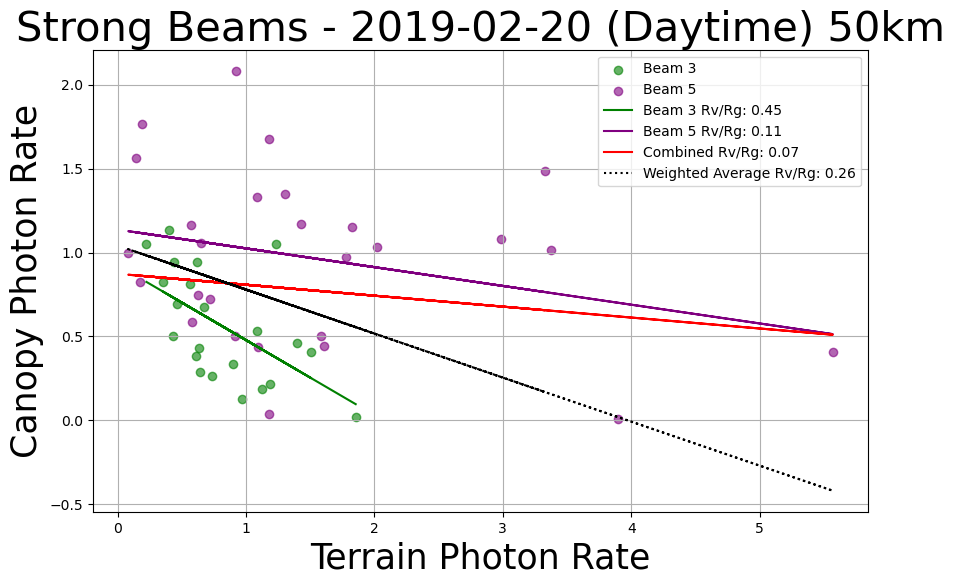

Plot saved as day/WREF/50/WREF_2019-02-20_strong_50km.png
No valid data for 2019-02-20 with weak beams. Skipping plot.


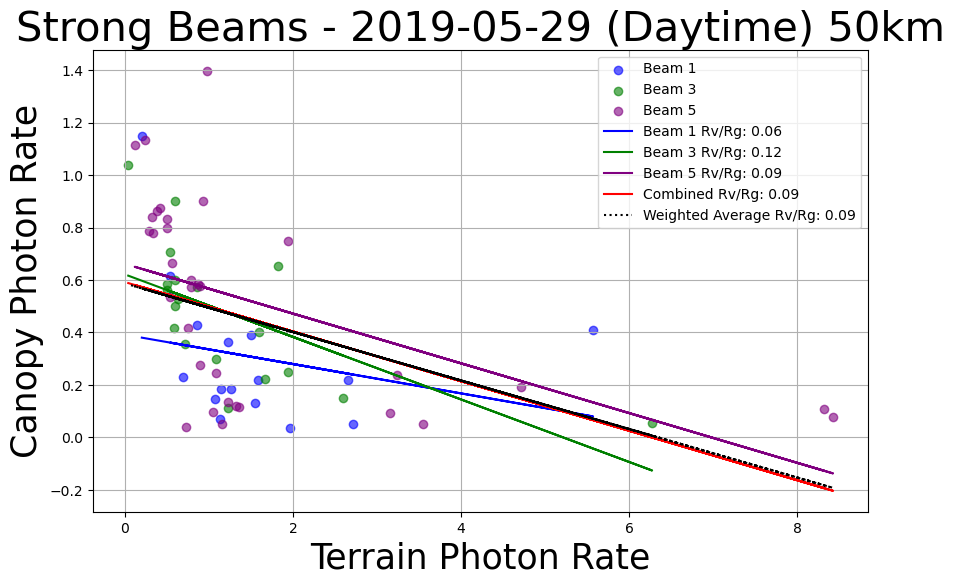

Plot saved as day/WREF/50/WREF_2019-05-29_strong_50km.png


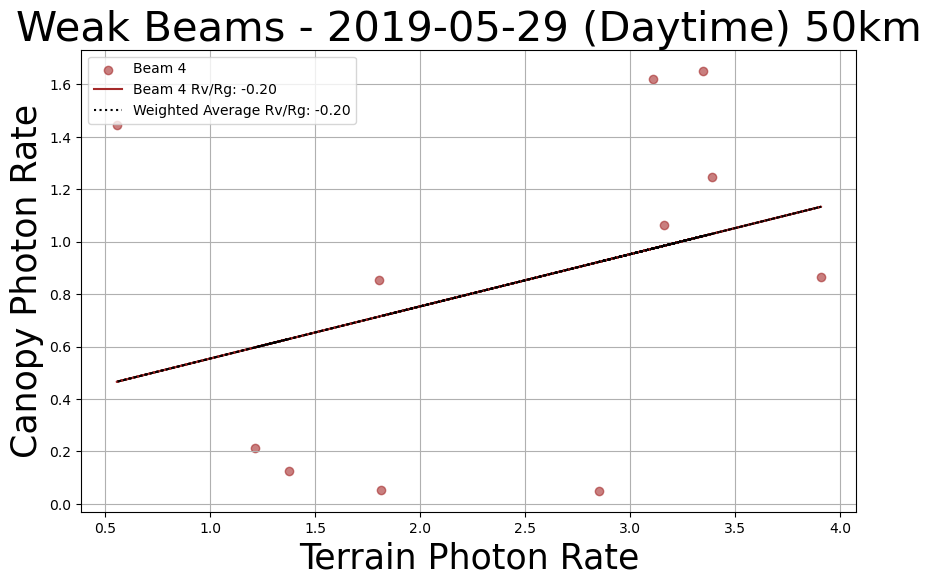

Plot saved as day/WREF/50/WREF_2019-05-29_weak_50km.png


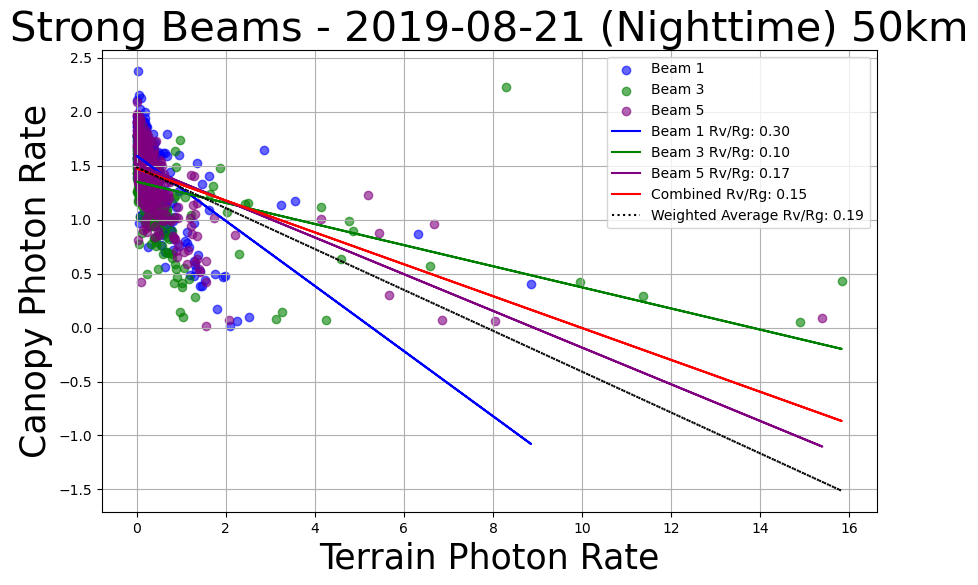

Plot saved as day/WREF/50/WREF_2019-08-21_strong_50km.png


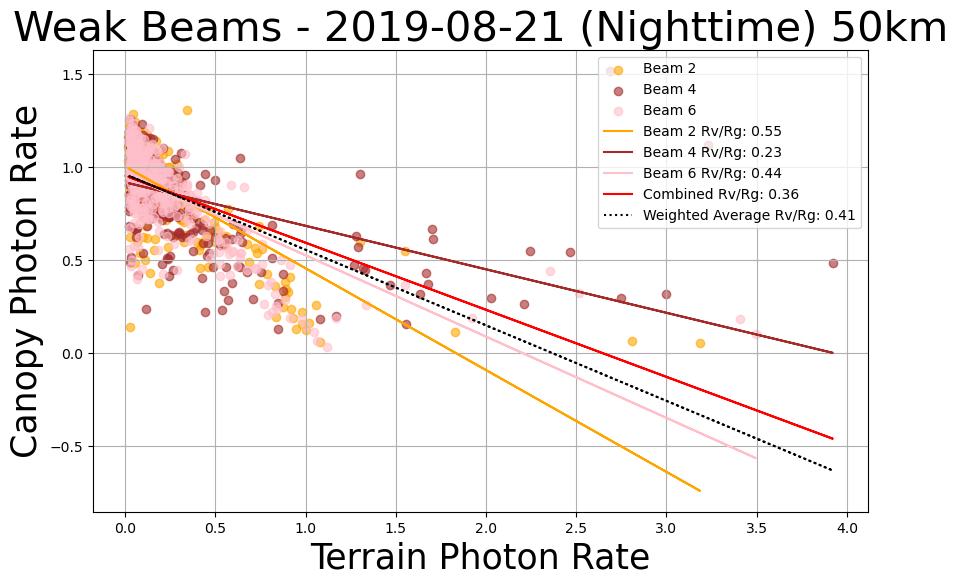

Plot saved as day/WREF/50/WREF_2019-08-21_weak_50km.png


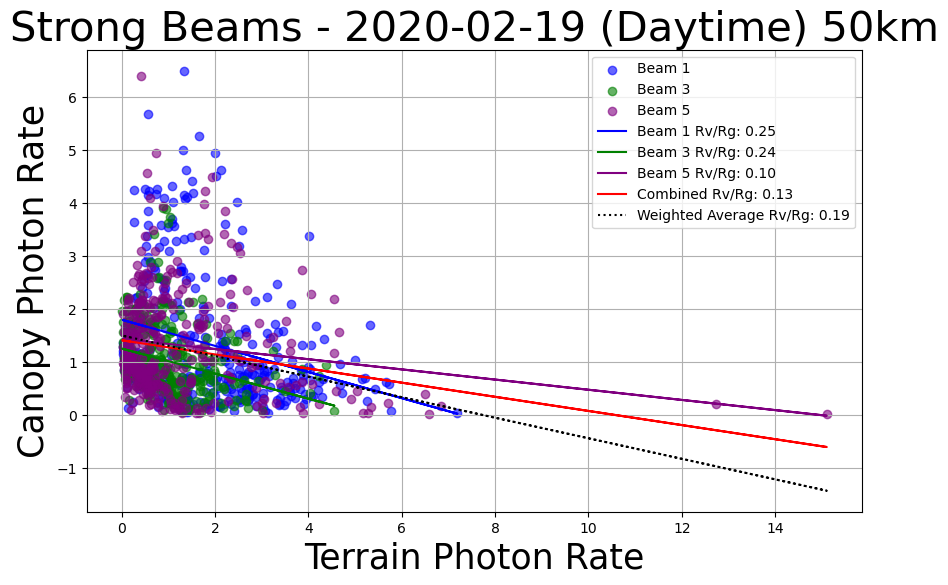

Plot saved as day/WREF/50/WREF_2020-02-19_strong_50km.png


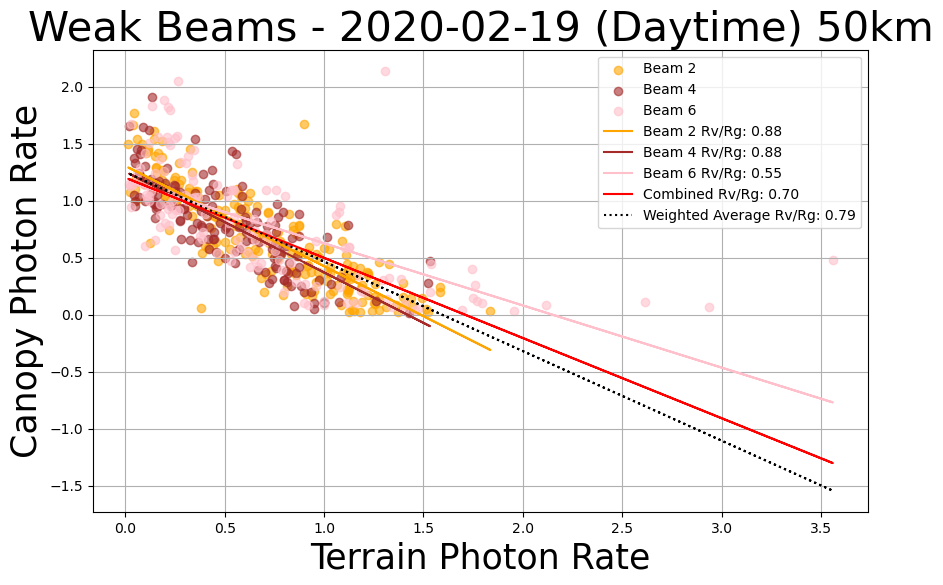

Plot saved as day/WREF/50/WREF_2020-02-19_weak_50km.png


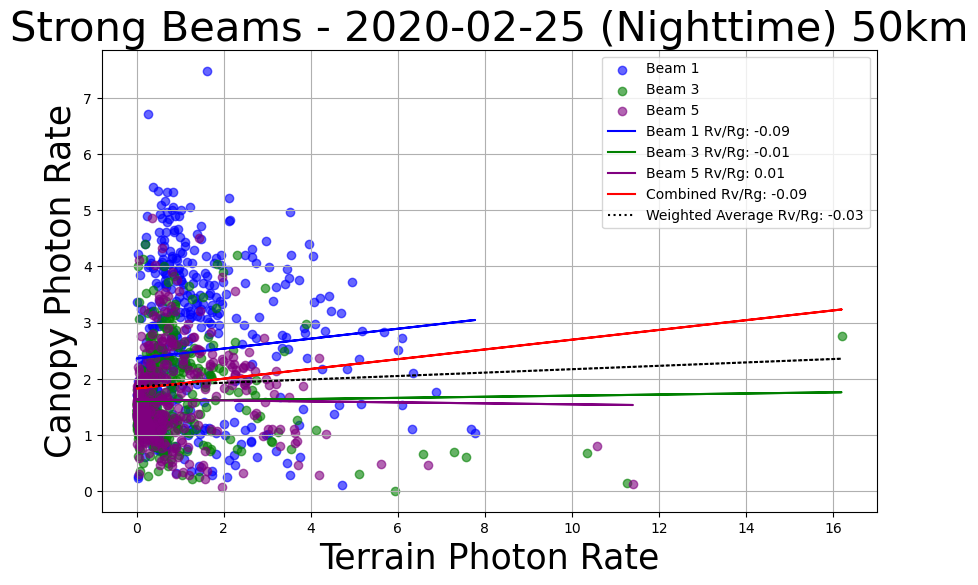

Plot saved as day/WREF/50/WREF_2020-02-25_strong_50km.png


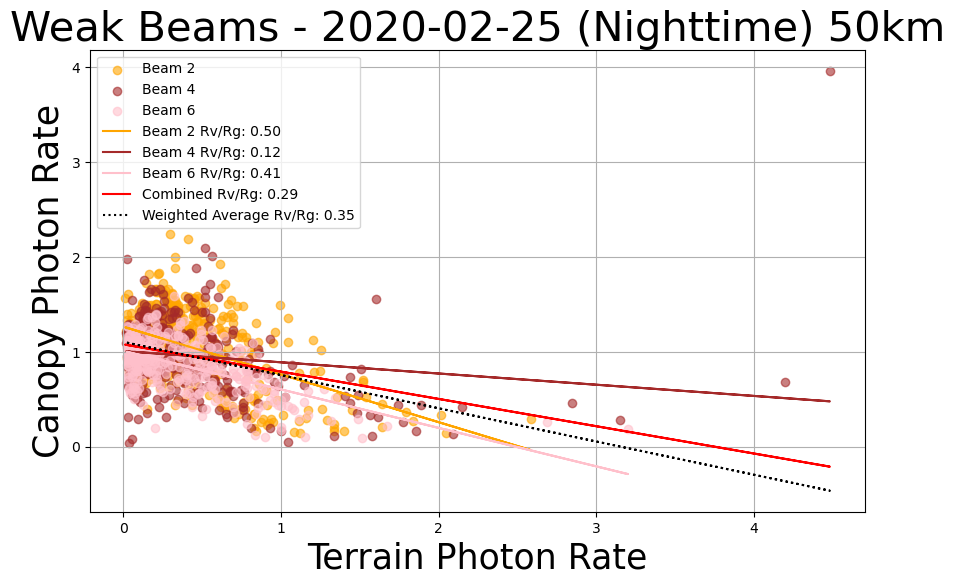

Plot saved as day/WREF/50/WREF_2020-02-25_weak_50km.png


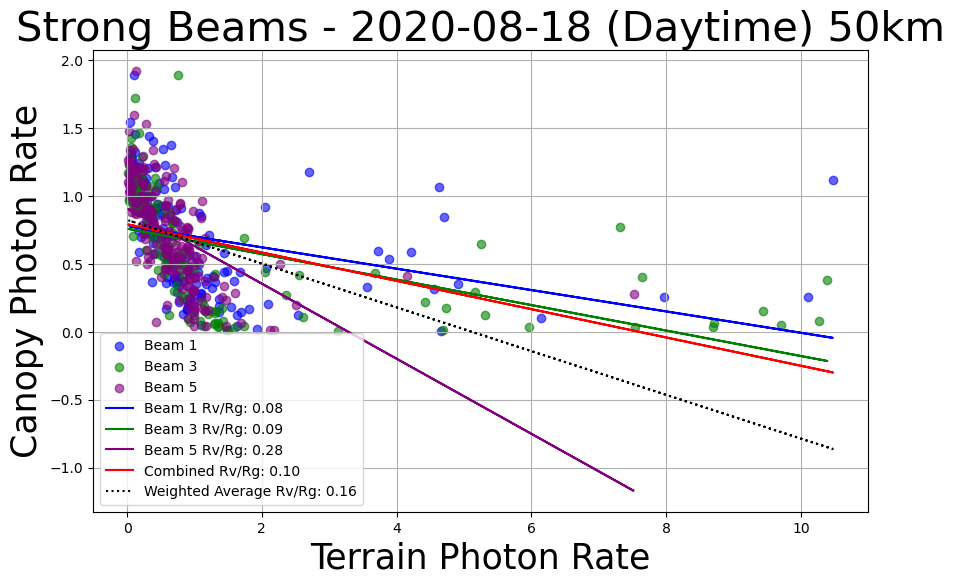

Plot saved as day/WREF/50/WREF_2020-08-18_strong_50km.png


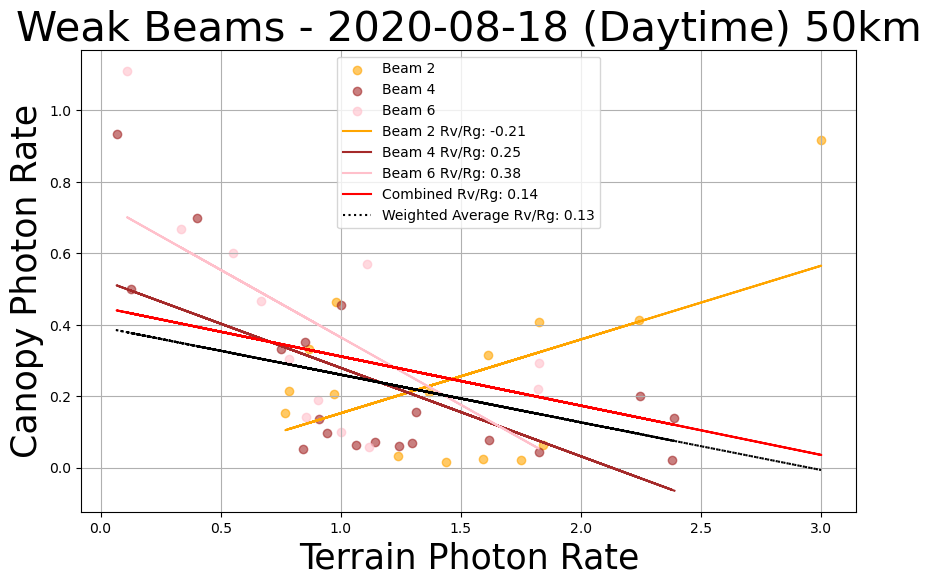

Plot saved as day/WREF/50/WREF_2020-08-18_weak_50km.png


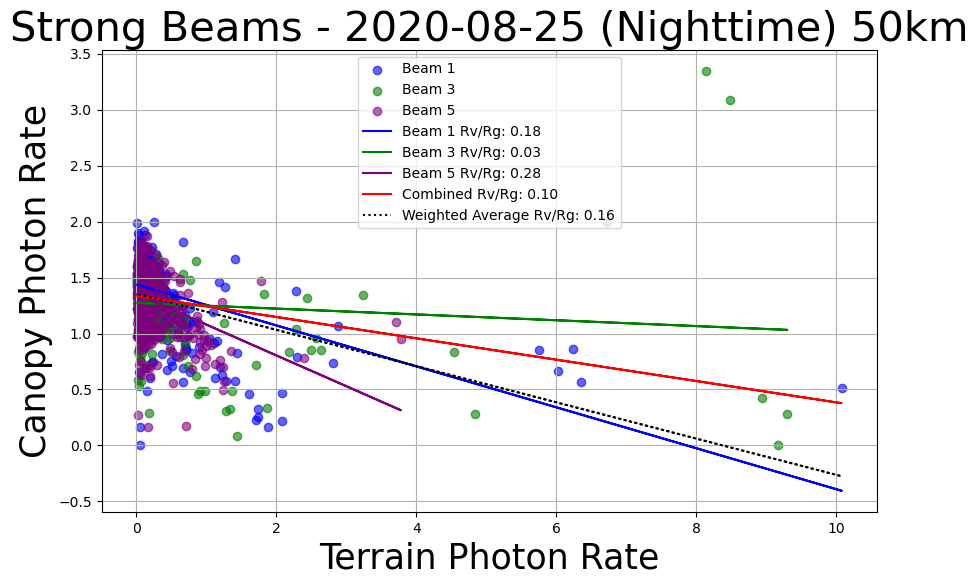

Plot saved as day/WREF/50/WREF_2020-08-25_strong_50km.png


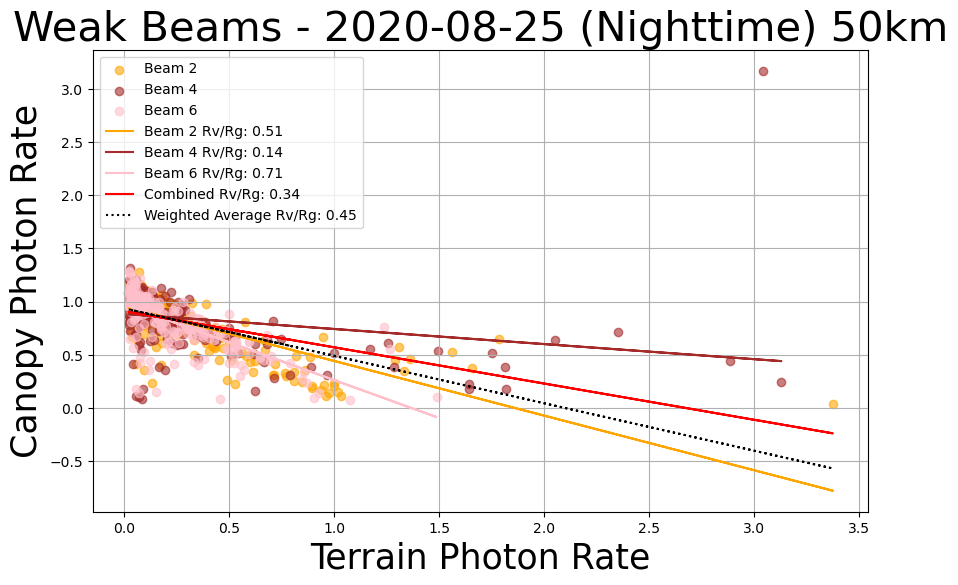

Plot saved as day/WREF/50/WREF_2020-08-25_weak_50km.png


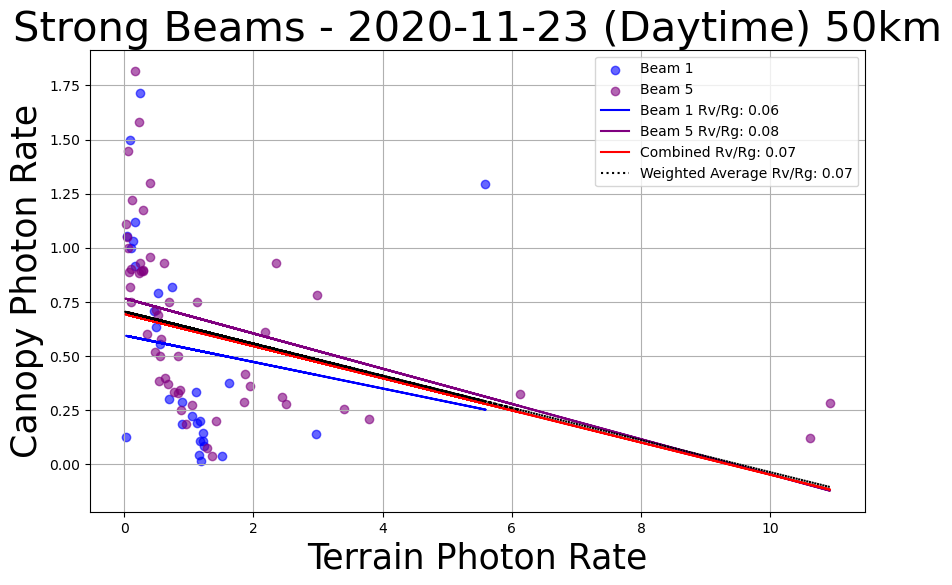

Plot saved as day/WREF/50/WREF_2020-11-23_strong_50km.png
No valid data for 2020-11-23 with weak beams. Skipping plot.


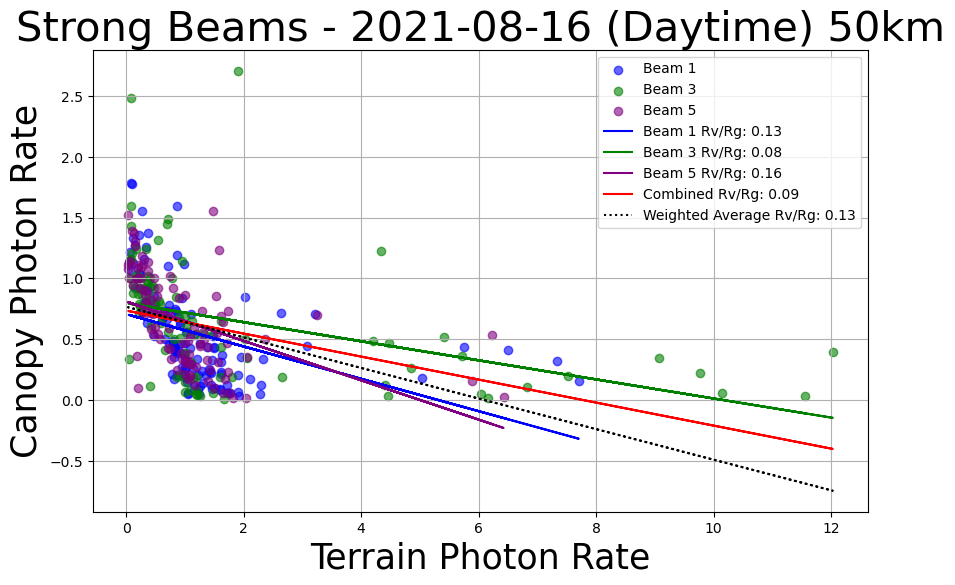

Plot saved as day/WREF/50/WREF_2021-08-16_strong_50km.png
No valid data for 2021-08-16 with weak beams. Skipping plot.


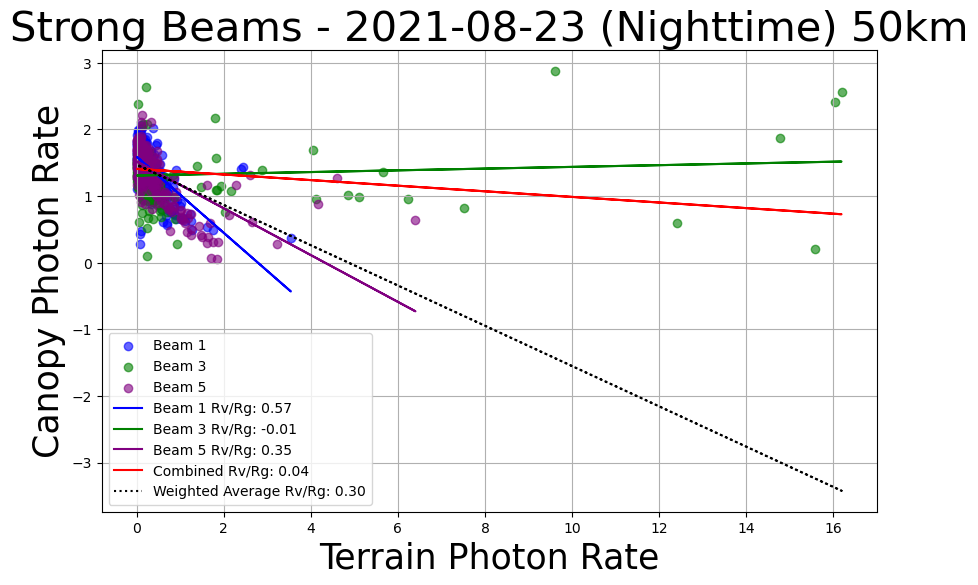

Plot saved as day/WREF/50/WREF_2021-08-23_strong_50km.png


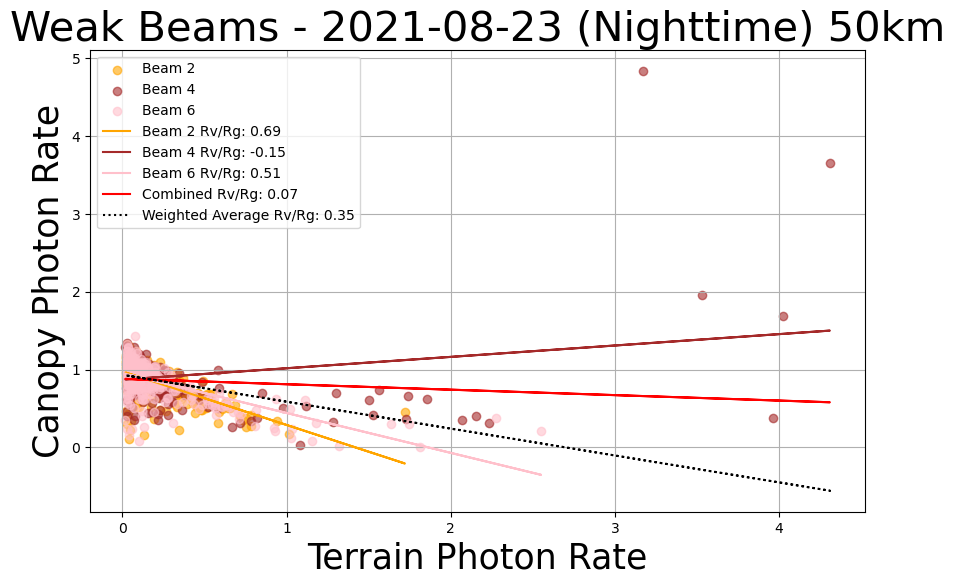

Plot saved as day/WREF/50/WREF_2021-08-23_weak_50km.png


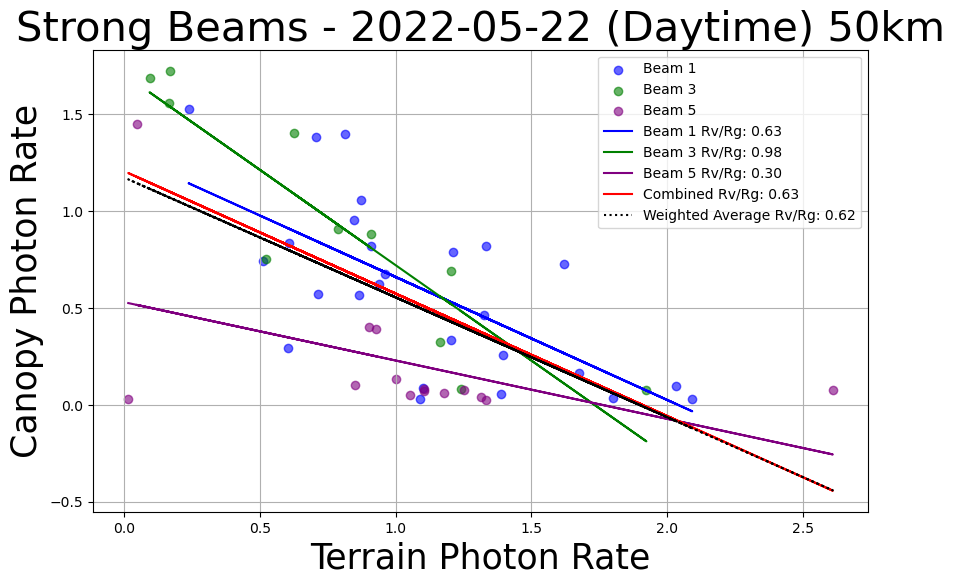

Plot saved as day/WREF/50/WREF_2022-05-22_strong_50km.png
No valid data for 2022-05-22 with weak beams. Skipping plot.


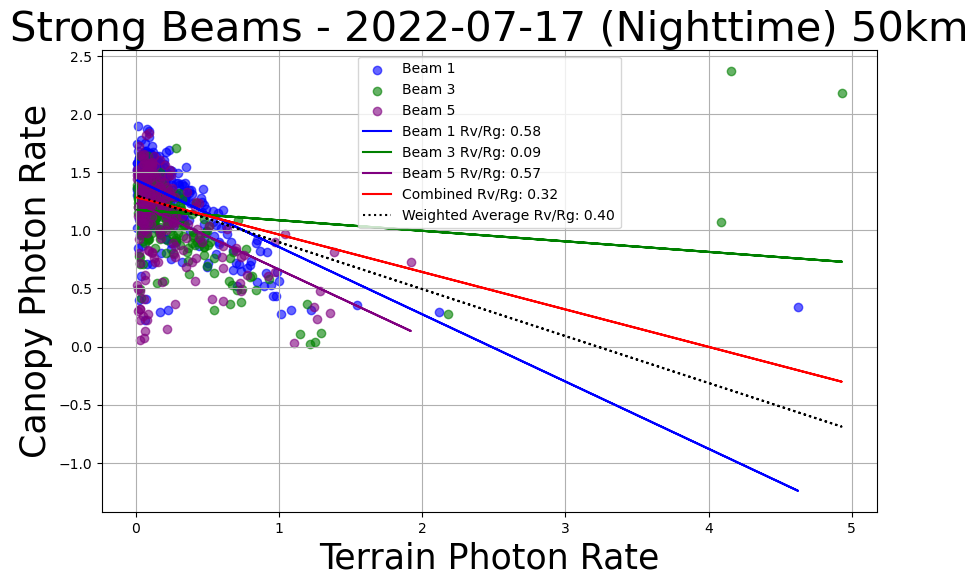

Plot saved as day/WREF/50/WREF_2022-07-17_strong_50km.png


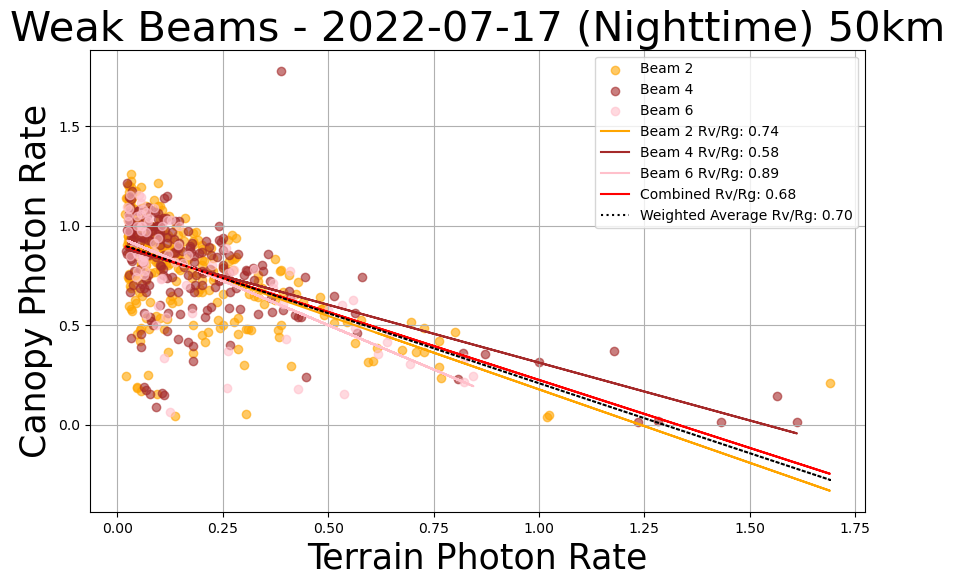

Plot saved as day/WREF/50/WREF_2022-07-17_weak_50km.png


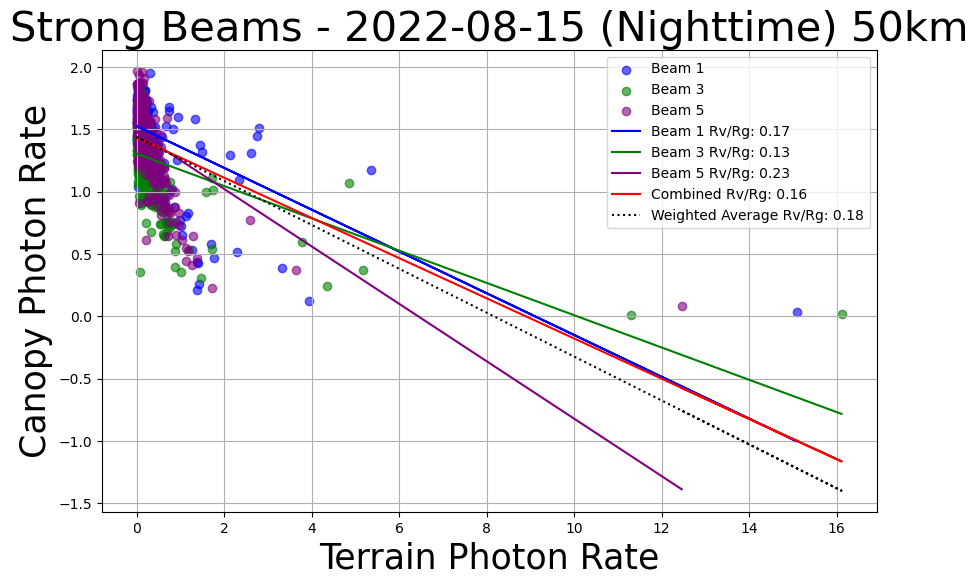

Plot saved as day/WREF/50/WREF_2022-08-15_strong_50km.png


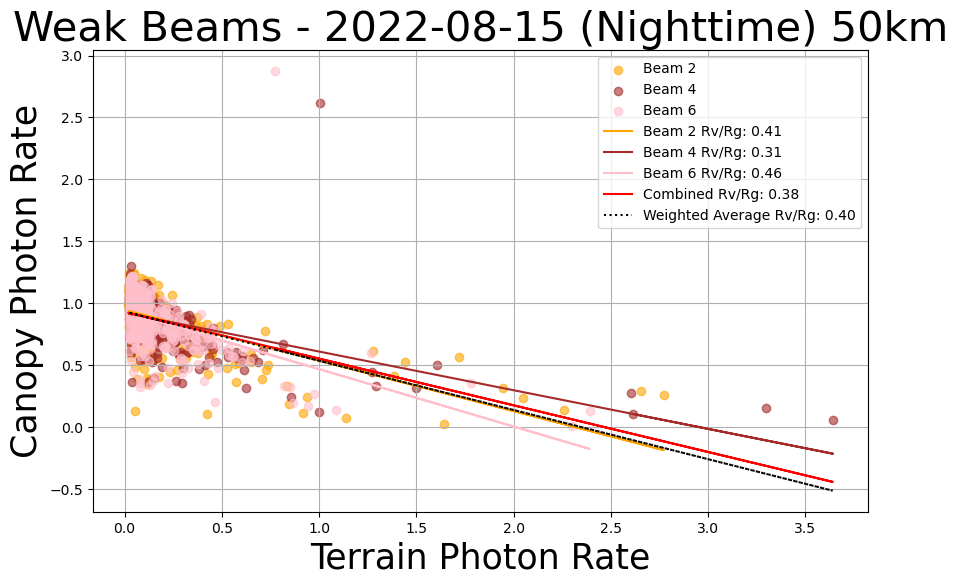

Plot saved as day/WREF/50/WREF_2022-08-15_weak_50km.png


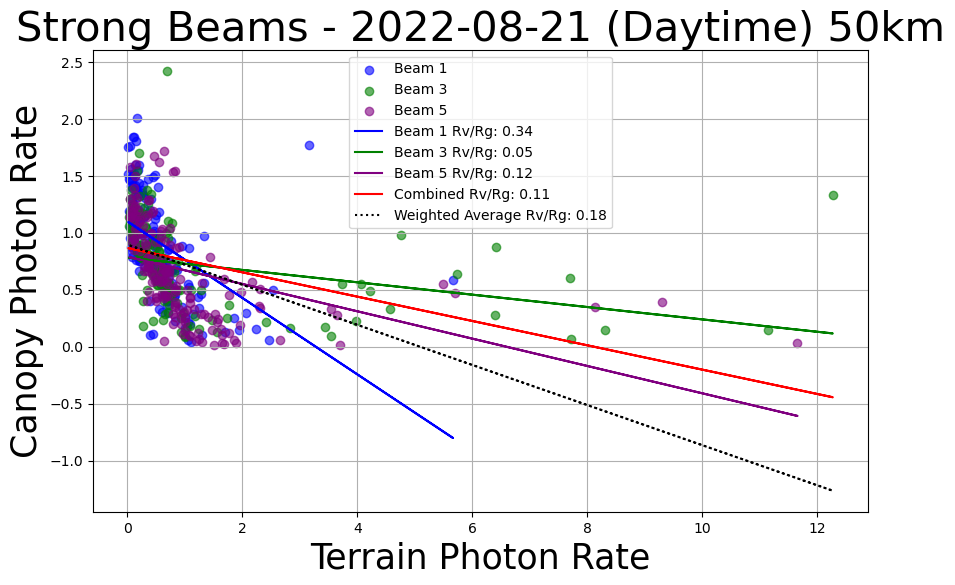

Plot saved as day/WREF/50/WREF_2022-08-21_strong_50km.png


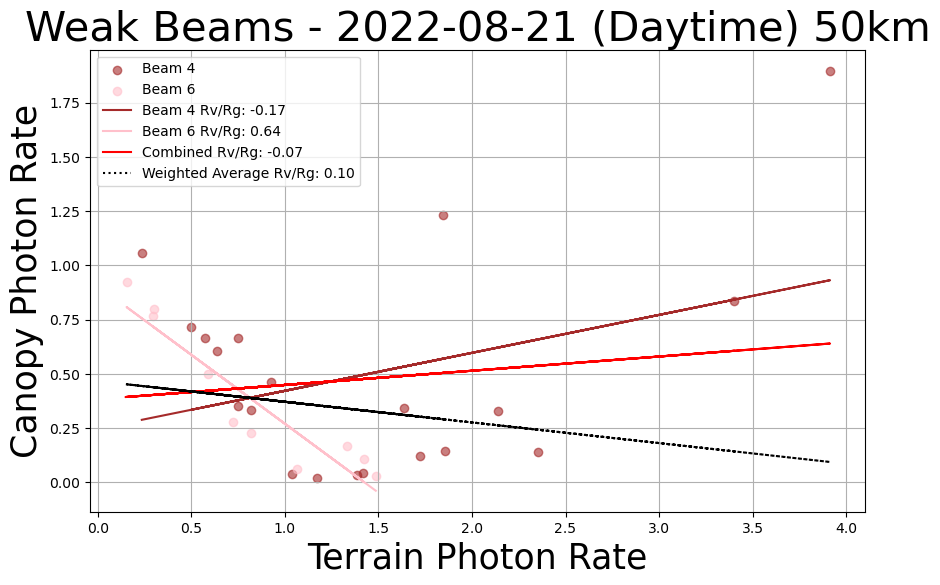

Plot saved as day/WREF/50/WREF_2022-08-21_weak_50km.png


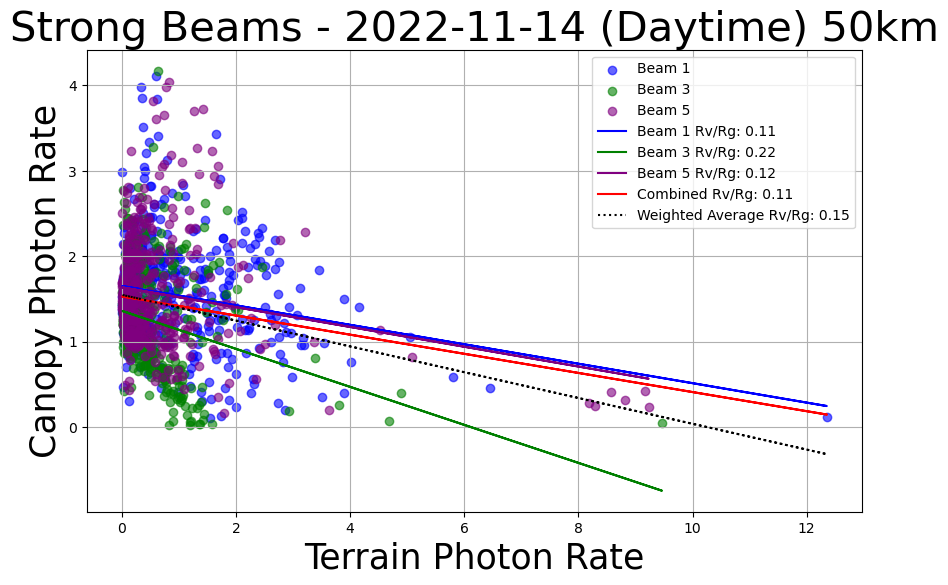

Plot saved as day/WREF/50/WREF_2022-11-14_strong_50km.png


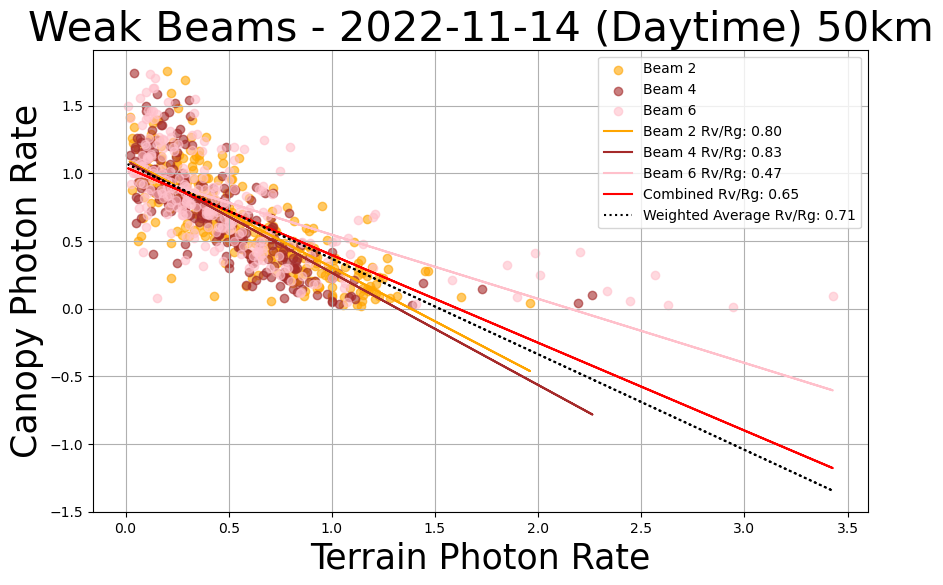

Plot saved as day/WREF/50/WREF_2022-11-14_weak_50km.png


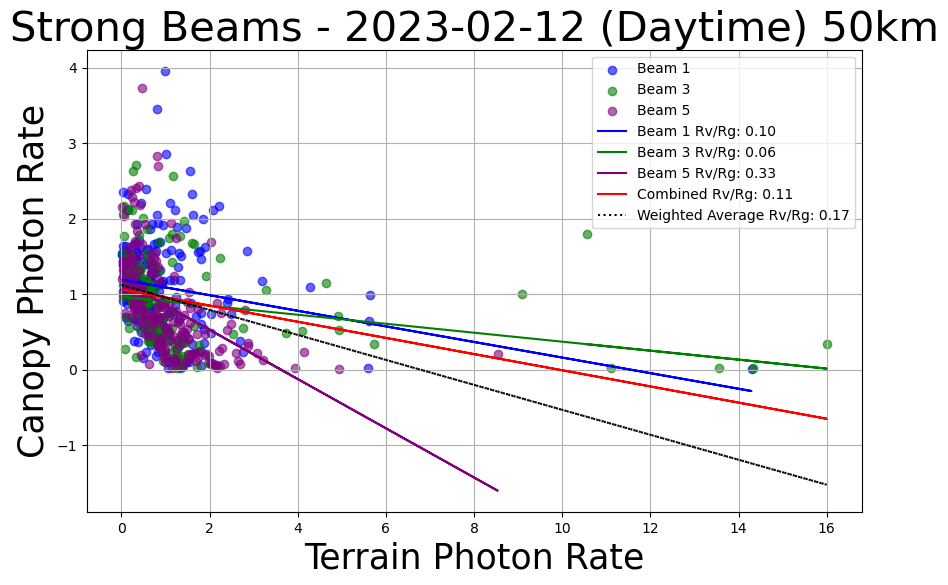

Plot saved as day/WREF/50/WREF_2023-02-12_strong_50km.png


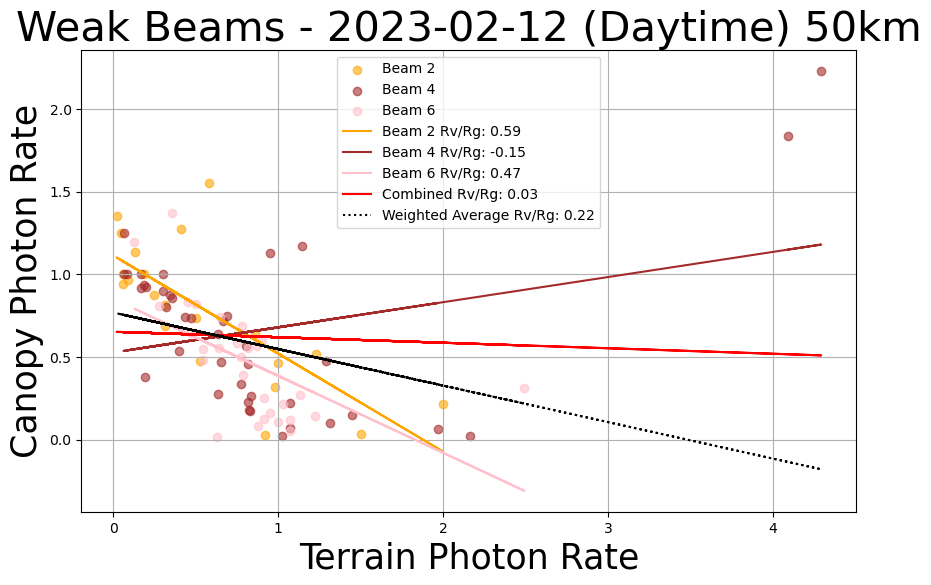

Plot saved as day/WREF/50/WREF_2023-02-12_weak_50km.png


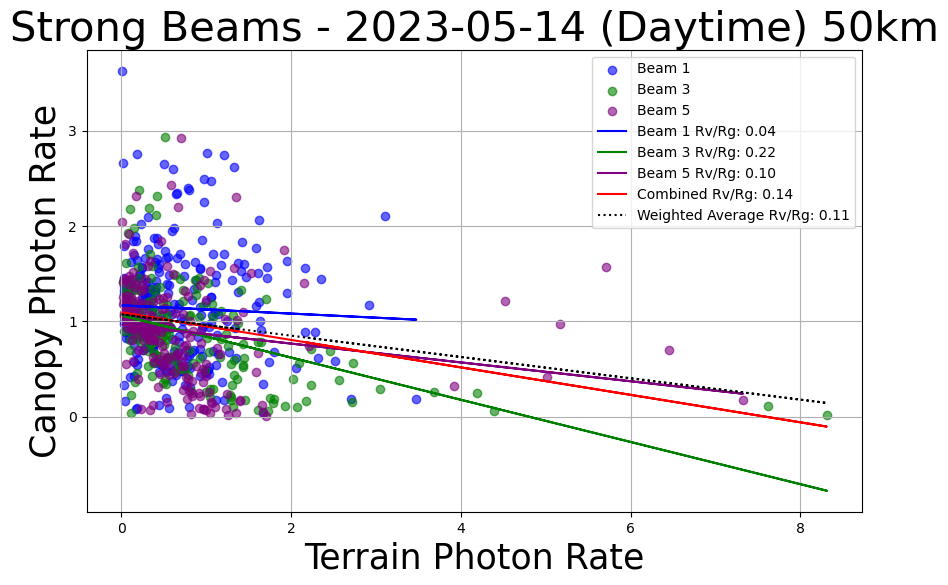

Plot saved as day/WREF/50/WREF_2023-05-14_strong_50km.png


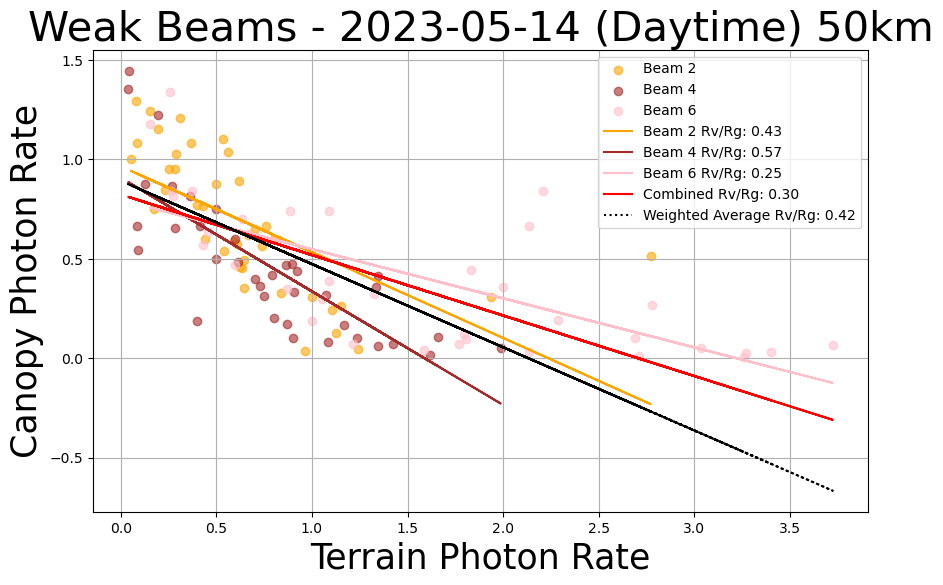

Plot saved as day/WREF/50/WREF_2023-05-14_weak_50km.png


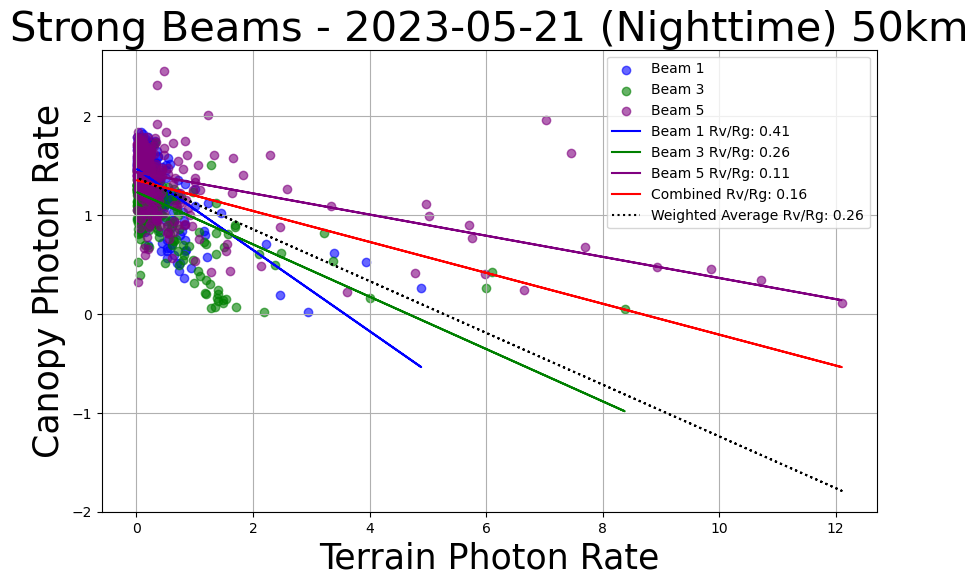

Plot saved as day/WREF/50/WREF_2023-05-21_strong_50km.png


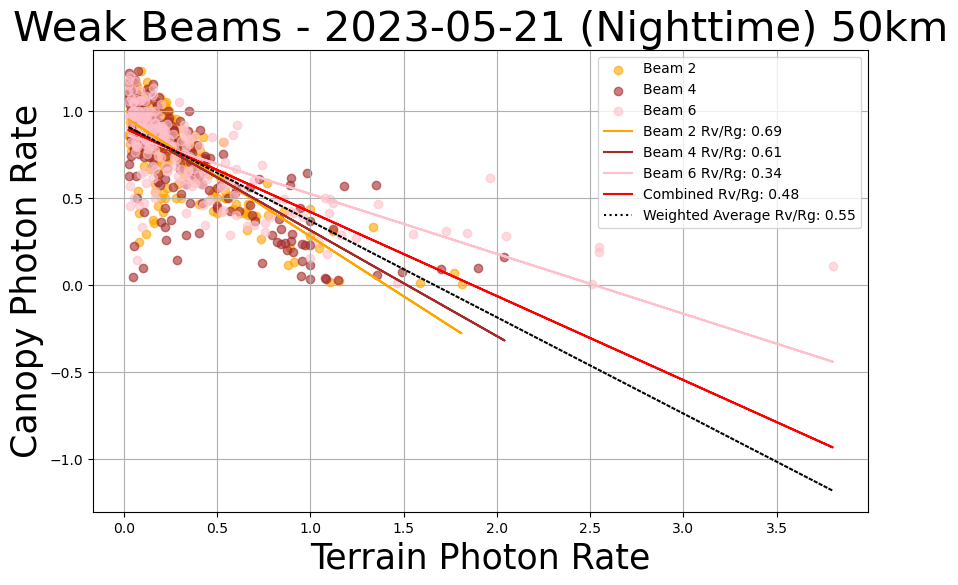

Plot saved as day/WREF/50/WREF_2023-05-21_weak_50km.png


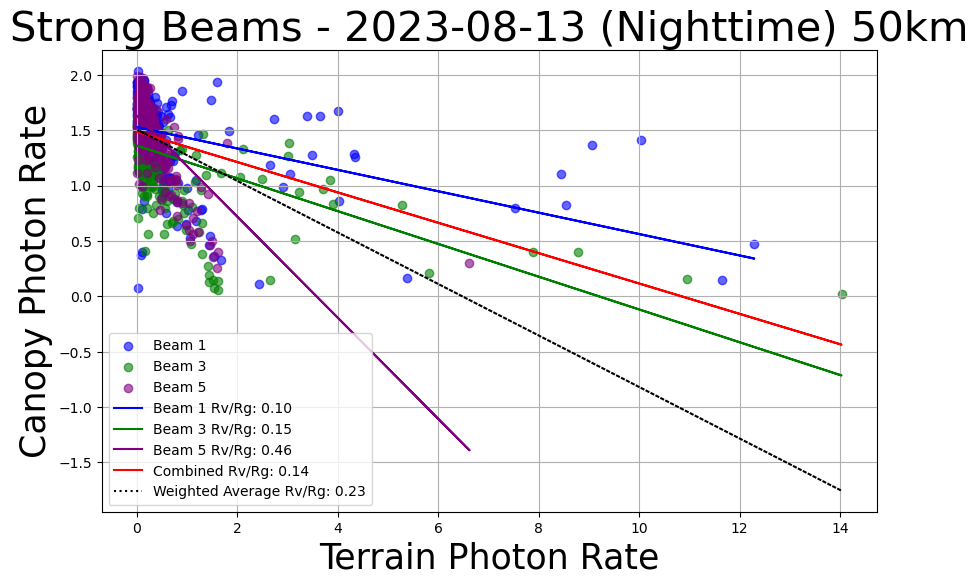

Plot saved as day/WREF/50/WREF_2023-08-13_strong_50km.png


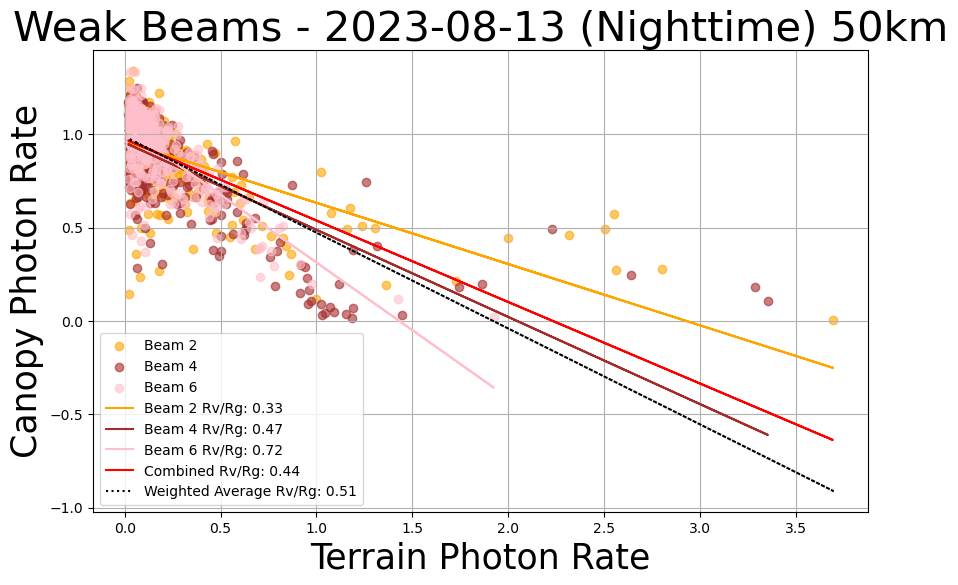

Plot saved as day/WREF/50/WREF_2023-08-13_weak_50km.png
No valid data for 2023-08-19 with strong beams. Skipping plot.
No valid data for 2023-08-19 with weak beams. Skipping plot.
CPU times: user 33.1 s, sys: 953 ms, total: 34.1 s
Wall time: 35.1 s


In [14]:
%%time
def plot_all_sites_photon(processed_site_data, folder, site_name, solar_elev_counts, boundary_km):
    """
    Plots photon rates for all dates and beam types (strong and weak) for a given site.
    Includes separate regressions for individual beams and an average Rv/Rg value.

    Args:
        processed_site_data (dict): The processed data for each site (with date as the key).
        folder (str): The folder where the plot should be saved.
        site_name (str): The name of the site for naming the plot file.

    Returns:
        dict: Regression results for each date and beam type.
    """
    regression_results = {'strong': {}, 'weak': {}}  # Separate results for strong and weak beam types
    colors = {1: 'blue', 3: 'green', 5: 'purple', 2: 'orange', 4: 'brown', 6: 'pink'}
    
    for date, data in processed_site_data.items():
        # Retrieve daytime/nighttime count for the current date
        daytime_count = solar_elev_counts.get(date, {}).get("daytime", 0)
        nighttime_count = solar_elev_counts.get(date, {}).get("nighttime", 0)

        # Determine the time of day for the plot title
        time_of_day = "Daytime" if daytime_count > nighttime_count else "Nighttime"
        
        for beam_type, beams in {'strong': [1, 3, 5], 'weak': [2, 4, 6]}.items():
            valid_data_found = False
            target_date = pd.to_datetime(date).date()
            data['constructed_date'] = pd.to_datetime(data[['year', 'month', 'day']])
            beam_filter = data['spot'].isin(beams)
            filtered_data = data[(data['constructed_date'].dt.date == target_date) & beam_filter]
            filtered_data = filtered_data.dropna(subset=['canopy_photon_rate', 'terrain_photon_rate'])
            filtered_data = filtered_data.drop_duplicates(subset=['canopy_photon_rate', 'terrain_photon_rate'])

            if filtered_data.empty:
                print(f"No data available for {target_date} with {beam_type} beams.")
                continue

            fig, ax = plt.subplots(figsize=(10, 6))

            # Scatterplot for all beams with >= 10 points
            for beam in beams:
                beam_data = filtered_data[filtered_data['spot'] == beam]
                if len(beam_data) >= 10:  # Only plot scatter for beams with >= 10 points
                    ax.scatter(beam_data['terrain_photon_rate'], beam_data['canopy_photon_rate'], color=colors[beam], label=f"Beam {beam}", alpha=0.6)
                    valid_data_found = True  # Mark that we have valid data for plotting

            # If no valid data for plotting, skip the plot entirely
            if not valid_data_found:
                print(f"No valid data for {date} with {beam_type} beams. Skipping plot.")
                plt.close()  # Close the plot if no valid data
                continue  # Skip to the next iteration of the loop without creating a plot

            # List to store Rv/Rg values for beams meeting the threshold
            beam_regression_results = []
            combined_regression_results = []  # New list to store combined regression Rv/Rg values
            weights = []  # Store corresponding weights (data points per beam)

            # Regression and individual beam plots
            for beam in beams:
                beam_data = filtered_data[filtered_data['spot'] == beam]
                if len(beam_data) >= 10:  # Only do regression if >= 10 points
                    slope, intercept, *_ = linregress(beam_data['terrain_photon_rate'], beam_data['canopy_photon_rate'])
                    regression_line = slope * beam_data['terrain_photon_rate'] + intercept
                    rv_rg = -1 * slope
                    ax.plot(beam_data['terrain_photon_rate'], regression_line, linestyle='-', label=f"Beam {beam} Rv/Rg: {rv_rg:.2f}", color=colors[beam])
                    beam_regression_results.append(rv_rg)
                    weights.append(len(beam_data))  # Use the number of data points as the weight
                    regression_results[beam_type].setdefault(date, {})[beam] = {'slope': slope, 'intercept': intercept}

            # Combined Regression for entire dataset calculation and plotting
            # Check if there are more than one valid regression results in the current date's beam regressions
            if len(beam_regression_results) > 1:
                # Perform the combined regression (for the entire dataset, not individual beams)
                combined_slope, combined_intercept, *_ = linregress(filtered_data['terrain_photon_rate'], filtered_data['canopy_photon_rate'])
                combined_line = combined_slope * filtered_data['terrain_photon_rate'] + combined_intercept
                combined_rv_rg = -1 * combined_slope
            
                # Plot the combined regression line
                ax.plot(filtered_data['terrain_photon_rate'], combined_line, color='red', label=f"Combined Rv/Rg: {combined_rv_rg:.2f}")
            
                # Store the combined Rv/Rg in the regression results separately
                regression_results[beam_type].setdefault(date, {})['combined'] = {'rv_rg': combined_rv_rg, 'slope': combined_slope, 'intercept': combined_intercept}

        
            # Weighted Average Rv/Rg calculation (only for beams with >= 10 points)
            if beam_regression_results:
                # Extract the slopes for valid beams
                valid_slopes = [regression_results[beam_type].get(date, {}).get(beam, {}).get('slope') for beam in beams if len(filtered_data[filtered_data['spot'] == beam]) >= 10 ]
                # Extract the intercepts for valid beams
                valid_intercepts = [regression_results[beam_type].get(date, {}).get(beam, {}).get('intercept') for beam in beams if len(filtered_data[filtered_data['spot'] == beam]) >= 10]
            
                # Calculate weighted average for intercepts
                weighted_avg_intercept = np.average(valid_intercepts, weights=weights)
                weighted_avg_slope = np.average(valid_slopes, weights=weights)
                weighted_avg_rv_rg = -weighted_avg_slope  # Since Rv/Rg = -slope
            
                # Plot the weighted average regression line using the weighted average slope and intercept
                avg_regression_line = weighted_avg_slope * filtered_data['terrain_photon_rate'] + weighted_avg_intercept
                ax.plot(filtered_data['terrain_photon_rate'], avg_regression_line, color='black', linestyle=':', label=f"Weighted Average Rv/Rg: {weighted_avg_rv_rg:.2f}")
            
                # Store the weighted average Rv/Rg in the regression results separately
                regression_results[beam_type].setdefault(date, {})['weighted_average'] = {'rv_rg': weighted_avg_rv_rg, 'slope': weighted_avg_slope, 'intercept': weighted_avg_intercept}

            # Plot settings
            ax.set_xlabel('Terrain Photon Rate', fontsize=25)
            ax.set_ylabel('Canopy Photon Rate', fontsize=25)
            ax.set_title(f'{beam_type.capitalize()} Beams - {target_date} ({time_of_day}) {boundary_km}km', fontsize=30)
            ax.legend(fontsize=10)
            ax.grid(True)

            # Only save and display the plot if something was actually plotted
            if valid_data_found:
                save_folder = os.path.join(folder, site_name, boundary_km)
                os.makedirs(save_folder, exist_ok=True)
                savefile = os.path.join(save_folder, f'{site_name}_{date}_{beam_type}_{boundary_km}km.png')
                plt.savefig(savefile, bbox_inches='tight', dpi=300)
                plt.show()
                print(f"Plot saved as {savefile}")
            else:
                plt.close()  # Close the figure if nothing was plotted
                
            plt.close()
    return regression_results

regression_results = plot_all_sites_photon(processed_site_data, day_folder, site_name, solar_elev_counts, boundary_km)

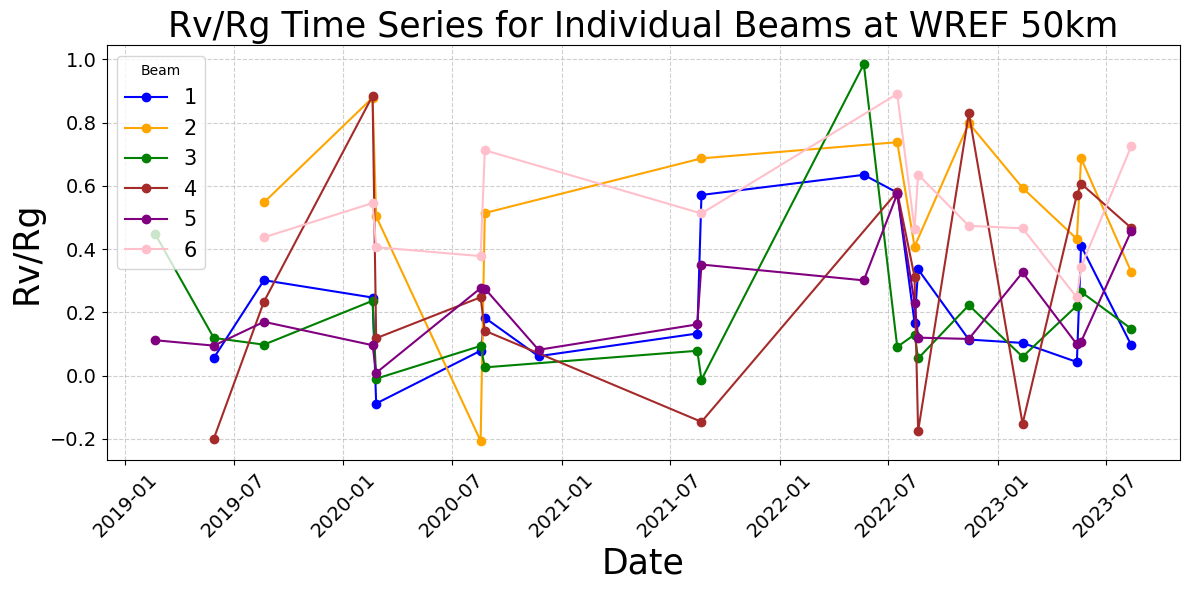

Plot saved: day/WREF/50/WREF_individual_beams_time_series_50km.png


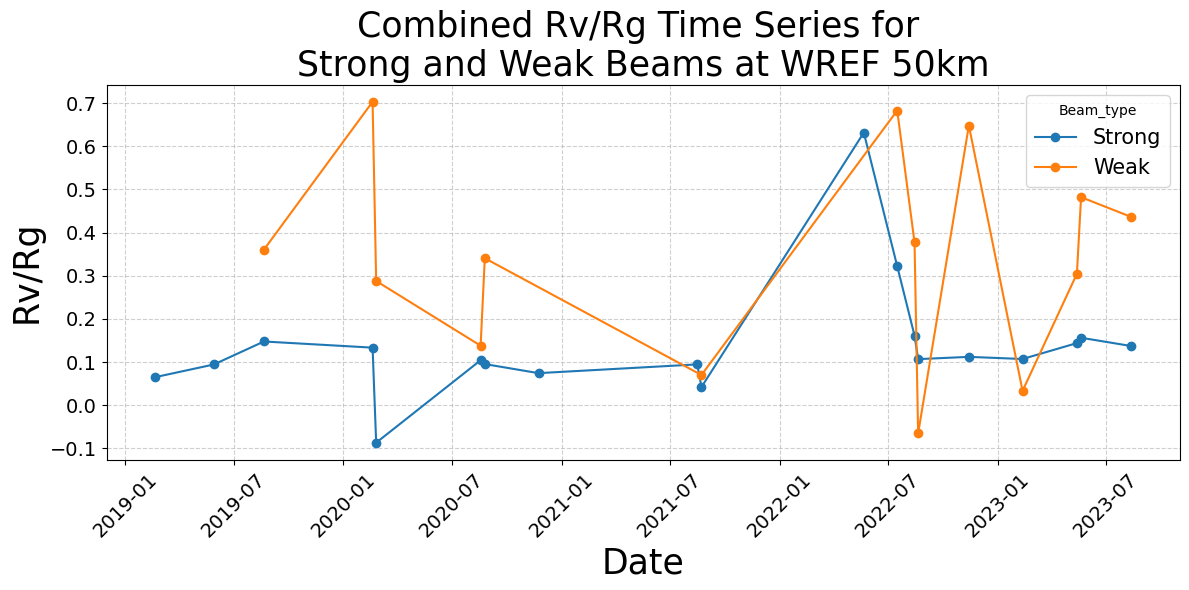

Plot saved: day/WREF/50/WREF_combined_beams_time_series_50km.png


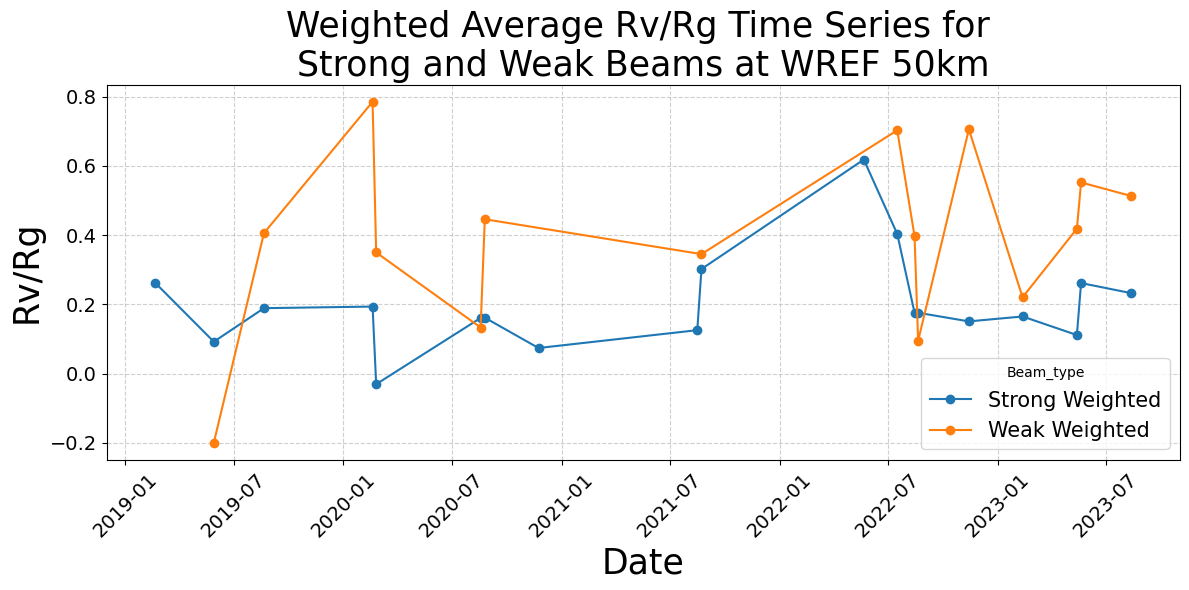

Plot saved: day/WREF/50/WREF_weighted_avg_beams_time_series_50km.png
CPU times: user 2.58 s, sys: 108 ms, total: 2.68 s
Wall time: 2.76 s


In [15]:
%%time
def plot_regression_time_series(regression_results, site_name, folder, boundary_km):
    """
    Plots time series of regression results for:
    1. Individual beams with different colors
    2. Strong and weak beams (combined regressions) with different colors
    3. Weighted averages for strong and weak beams with different colors
    
    Args:
        regression_results (dict): Regression results for strong and weak beams.
        site_name (str): The name of the site for naming the plot.
        folder (str): The folder where the plots should be saved.
    """
    # Colors for individual beams
    beam_colors = {1: 'blue', 3: 'green', 5: 'purple', 2: 'orange', 4: 'brown', 6: 'pink'}
    time_series_data = {
        'individual': [],
        'strong_combined': [],
        'weak_combined': [],
        'strong_weighted': [],
        'weak_weighted': []
    }
    
    # Prepare data for the plots
    for beam_type, date_results in regression_results.items():
        for date, results in date_results.items():
            # Parse date
            date_obj = pd.to_datetime(date)
            
            # Individual beams
            for beam, beam_result in results.items():
                if beam not in ['combined', 'weighted_average']:
                    rv_rg = -beam_result['slope']
                    time_series_data['individual'].append({'date': date_obj, 'beam': beam, 'rv_rg': rv_rg})
            
            # Combined regression
            if 'combined' in results:
                rv_rg = results['combined']['rv_rg']
                time_series_data[f"{beam_type}_combined"].append({'date': date_obj, 'rv_rg': rv_rg})
            
            # Weighted average
            if 'weighted_average' in results:
                rv_rg = results['weighted_average']['rv_rg']
                time_series_data[f"{beam_type}_weighted"].append({'date': date_obj, 'rv_rg': rv_rg})

    # Convert to DataFrames for easier plotting
    df_individual = pd.DataFrame(time_series_data['individual'])
    df_strong_combined = pd.DataFrame(time_series_data['strong_combined'])
    df_weak_combined = pd.DataFrame(time_series_data['weak_combined'])
    df_strong_weighted = pd.DataFrame(time_series_data['strong_weighted'])
    df_weak_weighted = pd.DataFrame(time_series_data['weak_weighted'])

    def plot_time_series(data, x_col, y_col, hue_col, title, y_label, save_name, color_map=None):
        fig, ax = plt.subplots(figsize=(12, 6))
        for key, group in data.groupby(hue_col):
            color = color_map.get(key, None) if color_map else None
            ax.plot(group[x_col], group[y_col], label=key, color=color, marker='o')
        
        # Title and labels
        ax.set_title(title, fontsize=25)
        ax.set_xlabel('Date', fontsize=25)
        ax.set_ylabel(y_label, fontsize=25)
        ax.tick_params(axis='x', rotation=45, labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        
        # Add legend
        ax.legend(title=hue_col.capitalize(), fontsize=15)
        
        # Add grid
        ax.grid(True, which='both', linestyle='--', alpha=0.6)
        
        # Save the plot
        savefolder = os.path.join(folder, site_name, boundary_km)

        # Create the directory structure if it doesn't exist
        if not os.path.exists(savefolder):
            os.makedirs(savefolder)
            print(f"Created directory: {savefolder}")
        
        savefile = os.path.join(savefolder, f"{site_name}_{save_name}_{boundary_km}km.png")
        plt.tight_layout()
        plt.savefig(savefile, dpi=300)
        plt.show()
        print(f"Plot saved: {savefile}")
    
    # Plot 1: Individual beams
    if not df_individual.empty:
        plot_time_series(data=df_individual, x_col='date', y_col='rv_rg', hue_col='beam', title=f"Rv/Rg Time Series for Individual Beams at {site_name} {boundary_km}km", y_label='Rv/Rg', save_name='individual_beams_time_series', color_map=beam_colors)

    # Plot 2: Strong and weak combined regressions
    if not df_strong_combined.empty or not df_weak_combined.empty:
        combined_df = pd.concat([df_strong_combined.assign(beam_type='Strong'), df_weak_combined.assign(beam_type='Weak')])  
        plot_time_series(data=combined_df, x_col='date', y_col='rv_rg', hue_col='beam_type', title=f"Combined Rv/Rg Time Series for \nStrong and Weak Beams at {site_name} {boundary_km}km", y_label='Rv/Rg', save_name='combined_beams_time_series')
            
    # Plot 3: Weighted averages for strong and weak beams
    if not df_strong_weighted.empty or not df_weak_weighted.empty:
        weighted_df = pd.concat([df_strong_weighted.assign(beam_type='Strong Weighted'), df_weak_weighted.assign(beam_type='Weak Weighted')])  
        plot_time_series(data=weighted_df, x_col='date', y_col='rv_rg', hue_col='beam_type', title=f"Weighted Average Rv/Rg Time Series for \nStrong and Weak Beams at {site_name} {boundary_km}km", y_label='Rv/Rg', save_name='weighted_avg_beams_time_series')

plot_regression_time_series(regression_results, site_name, day_folder, boundary_km)

In [16]:
def output_regression_results_after_date(regression_results, date_cutoff='2023-07-01'):
    """
    Outputs the regression results for each beam, combined regression, and weighted regression
    after a specified date.

    Args:
        regression_results (dict): The regression results for each beam and the combined/weighted results.
        date_cutoff (str): The cutoff date in 'YYYY-MM-DD' format. Default is '2023-07-01'.

    Returns:
        None
    """
    # Convert the cutoff date to a datetime object
    date_cutoff = pd.to_datetime(date_cutoff)

    # Loop through the regression results and output results after the cutoff date
    for beam_type in ['strong', 'weak']:
        print(f"\n{beam_type.capitalize()} Beams Regression Results After {date_cutoff.date()}:")

        for date, results in regression_results[beam_type].items():
            # Filter by date after the cutoff
            if pd.to_datetime(date) >= date_cutoff:
                print(f"\nResults for {date}:")
                
                # For each beam, output its regression results (slope, intercept, Rv/Rg)
                for beam, result in results.items():
                    if beam != 'combined' and beam != 'weighted_average':  # Exclude combined and weighted average from individual beams
                        print(f"  Beam {beam}:")
                        print(f"    Slope: {result['slope']}")
                        print(f"    Intercept: {result['intercept']}")
                        print(f"    Rv/Rg: {-result['slope']}")
                
                # Output combined regression results
                if 'combined' in results:
                    print(f"  Combined Regression:")
                    print(f"    Slope: {results['combined']['slope']}")
                    print(f"    Intercept: {results['combined']['intercept']}")
                    print(f"    Rv/Rg: {-results['combined']['slope']}")
                
                # Output weighted average regression results
                if 'weighted_average' in results:
                    print(f"  Weighted Average Regression:")
                    print(f"    Slope: {results['weighted_average']['slope']}")
                    print(f"    Intercept: {results['weighted_average']['intercept']}")
                    print(f"    Rv/Rg: {-results['weighted_average']['slope']}")

# Example usage
output_regression_results_after_date(regression_results, '2023-07-01')


Strong Beams Regression Results After 2023-07-01:

Results for 2023-08-13:
  Beam 1:
    Slope: -0.09667681701004617
    Intercept: 1.5301897160858822
    Rv/Rg: 0.09667681701004617
  Beam 3:
    Slope: -0.14810437941185262
    Intercept: 1.363268742675432
    Rv/Rg: 0.14810437941185262
  Beam 5:
    Slope: -0.4568270015386492
    Intercept: 1.636589560046336
    Rv/Rg: 0.4568270015386492
  Combined Regression:
    Slope: -0.13719646183242745
    Intercept: 1.4887434465420157
    Rv/Rg: 0.13719646183242745
  Weighted Average Regression:
    Slope: -0.2327307629194651
    Intercept: 1.5093017862553624
    Rv/Rg: 0.2327307629194651

Weak Beams Regression Results After 2023-07-01:

Results for 2023-08-13:
  Beam 2:
    Slope: -0.32817476570126064
    Intercept: 0.9615415319157479
    Rv/Rg: 0.32817476570126064
  Beam 4:
    Slope: -0.46677593715181614
    Intercept: 0.9554216065843946
    Rv/Rg: 0.46677593715181614
  Beam 6:
    Slope: -0.7248463839711679
    Intercept: 1.038251159406881